In [54]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')
import gc

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import matplotlib.patches as patches
from scipy import stats
from scipy.stats import skew

from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
pd.set_option('max_columns', 100)

py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import os,random, math, psutil, pickle
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from tqdm import tqdm

from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, Dropout
from keras.optimizers import Adam, Adagrad
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

In [129]:
sheets = pd.read_excel("Analytics_Case_Data.xlsx", sheet_name=None)

In [130]:
# filling in ...
for sheet_name in sheets.keys():
    sheets[sheet_name] = sheets[sheet_name].ffill(axis = 0)
    #sheets[sheet_name] = pd.to_numeric(sheets[sheet_name], errors='ignore')
    #sheets[sheet_name] = sheets[sheet_name].apply(lambda X: pd.to_numeric(X, errors='ignore'), axis=1)

In [131]:
# Removing the hoist apartments.
sheets['Floor 1'] = sheets['Floor 1'].drop('APT 3', axis=1)
sheets['Floor 2'] = sheets['Floor 2'].drop('APT 4', axis=1)
sheets['Floor 3'] = sheets['Floor 3'].drop('APT 4', axis=1)
sheets['Floor 4'] = sheets['Floor 4'].drop('APT 4', axis=1)
sheets['Floor 5'] = sheets['Floor 5'].drop('APT 4', axis=1)
sheets['Floor 1 (last week)'] = sheets['Floor 1 (last week)'].drop('APT 3', axis=1)
sheets['Floor 2 (last week)'] = sheets['Floor 2 (last week)'].drop('APT 4', axis=1)
sheets['Floor 3 (last week)'] = sheets['Floor 3 (last week)'].drop('APT 4', axis=1)
sheets['Floor 4 (last week)'] = sheets['Floor 4 (last week)'].drop('APT 4', axis=1)
sheets['Floor 5 (last week)'] = sheets['Floor 5 (last week)'].drop('APT 4', axis=1)

In [85]:
today = datetime.strptime('2018-03-31', '%Y-%m-%d')

# Senior manager

The aim of the following analysis is to answer these questions:
1. *How has the project progressed this week?*
2. *Is the project delayed, and if so, how much?*
3. *Are there indications of deep issues?*


The following chart shows the completion ratio of tasks for each floor. (The hoist apartments are not included.) Note that these Include fractional completions of tasks, and thus do not show how many tasks are fully complete.

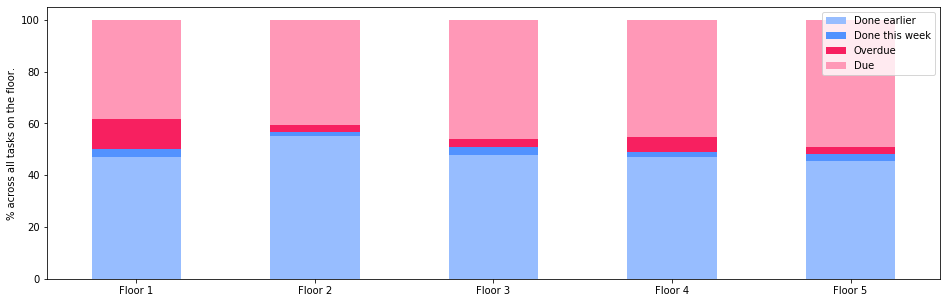

In [182]:
def overdue_ratio(floor):
    
    floor_df = sheets['Floor ' + str(floor)]
    
    # The total amount of tasks on the floor. 4 is taken away from 
    # the amount of columns to yield the amount of APT columns.
    tasks_n = floor_df.shape[0] * (floor_df.shape[1] - 4)
    
    past_deadlines = floor_df[floor_df['PLANNED END'] <= today]
    
    overdues = 0
    for index, row in past_deadlines.iterrows():
        for x in row[4:]:
            if x < 100:
                overdues += 100 - x
    
    return overdues / tasks_n

def done_this_week_ratio(floor):
    current_floor_df = sheets['Floor ' + str(floor)]
    previous_floor_df = sheets['Floor ' + str(floor) + ' (last week)']
    
    tasks_n = current_floor_df.shape[0] * (current_floor_df.shape[1] - 4)
    
    difs_sum = 0
    for name, col in current_floor_df.iloc[:, 4:].iteritems():
        difs_series = current_floor_df[name] - previous_floor_df[name]
        difs_sum += difs_series.sum()
    
    return difs_sum / tasks_n

def complete_ratio(floor):
    df = sheets['Overall']
    return df['FLOOR ' + str(floor)].mean()

    
complete_ratios = []
done_this_week_ratios = []
due_ratios = []
overdue_ratios = []
for i in range(5):
    c, d, o = complete_ratio(i+1), done_this_week_ratio(i+1), overdue_ratio(i+1)
    complete_ratios.append(c - d), done_this_week_ratios.append(d), overdue_ratios.append(o), due_ratios.append(100 - c - o)

floors = ['Floor ' + str(i+1) for i in range(5)]

barplot_df = pd.DataFrame(list(zip(complete_ratios, 
                                   done_this_week_ratios, 
                                   overdue_ratios, 
                                   due_ratios)), 
                          columns=['Done earlier', 'Done this week', 'Overdue', 'Due'], index=floors)

barplot_df.plot(kind='bar', stacked=True, legend=False, color=['#97BDFF', '#5292FF', '#F72060', '#FF98B7'], figsize=(16,5))
plt.xticks(rotation=0)
plt.ylabel('% across all tasks on the floor.')
_ = plt.legend(loc="upper right")

In [277]:
np.array([104,
107,
120,
135,
146]) / 7

array([14.85714286, 15.28571429, 17.14285714, 19.28571429, 20.85714286])

In [275]:
for i, j in zip((due_ratios + overdue_ratios), done_this_week_ratios):
    print(i/j)

12.71523178807947
27.851851851851848
14.264214046822742
26.984251968503933
20.119565217391305


The mean amount of tasks that were done this week (not necessarily completed, but done to some degree) is around **2.4%** of all tasks. If this weekly speed persists, the overdue tasks would take on average about 2 weeks to complete (if they were focused on solely), and the whole project would take about 18 weeks (about 8 weeks excluding *Commission + Inspect*). 

And looking at the floors' individual speeds, if they persist, the deadline of the final task of Floor 2 would be missed by about a week, and that of Floor 4 by four weeks (both by about eight weeks excluding *Commission + Inspect*), while the others would be met.

Unfortunately all floors have overdue tasks, with a mean of around **5%** of all tasks across the floors. Floor 1 is in particularly bad shape, with as much as **12%** overdue, despite the fact that Floor 1 was begun the earliest and has the least amount of apartments. 

# Construction manager

The aim of the following analysis is to answer the question *What is the state of each floor, and are there indications of egregious delays?* 

To answer it, below is a heatmap for each floor, showing the latest completion ratio of each task (excluding those of the hoist apartments). The cells representing overdue tasks have been outlined in red. (The taskgroups **Flooring Installation**; **Apartment Final Decoration**; and **Commission + Inspect** have been omitted, since none of their tasks have been started on any floor, while the taskgroups **Apartment core** and **M&E 1st Fix and Pod Positioning** have been omitted because they are 100% complete on every floor.)

**Observations**

1. Floor 2 is in the most advanced state, with a mean completion rate of its tasks of 88%. As the mean of the completion rates between the other four floors is around 70%, the distribution of time and manpower across the floors should be checked.
2. For some reason, the *Internal Walls Structure & Boarding* task is unfinished in Apartment 1 in three of the floors, without any progress from last week. Though this may be due to those apartments' special locations, so that some spatial dependency has up to now prevented finishing them, it may be worth checking out the cause anyway.  



In [289]:
omit_taskgroups = ['Flooring Installation, Kitchen Units ',
                   'Apartment Final Decoration',
                   'Commission + Inspect',
                   'Apartment Core',
                   'M&E 1st Fix and Pod Positioning'
                  ]

def floor_heatmap(floor):
    fig = plt.figure(figsize=(17,6), dpi=150)

    floor_df = sheets['Floor ' + str(floor)]
    floor_df = floor_df[floor_df['TASK'] != 'Kitchen Walls - Decoration, Tape & Joint ']
    for taskgroup in omit_taskgroups:
        floor_df = floor_df[floor_df['TASKGROUP'] != taskgroup]

    past_deadlines = floor_df[floor_df['PLANNED END'] <= today]
    #next_week_deadlines = matrix[(matrix['PLANNED END'] > today)
    #                           & (matrix['PLANNED END'] < today + timedelta(days=7))]
    
    overdues = past_deadlines.iloc[:, 4:] < 100
    #due_next_week = next_week_deadlines.iloc[:, 4:]
    
    floor_df = floor_df.drop(['TASKGROUP', 'PLANNED START', 'PLANNED END'], axis=1)
    floor_df = floor_df.set_index('TASK')
    ax = sns.heatmap(floor_df.T, cmap='Blues', cbar_kws={'label': '% complete'})

    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    ax.set_title('Floor {} task completion'.format(floor), fontsize=20, pad=15)
    ax.xaxis.label.set_visible(False)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)

    
    from matplotlib.patches import Rectangle
    for index, x in np.ndenumerate(overdues):
        if x:
            ax.add_patch(Rectangle((index[0], index[1]), 1, 1, fill=False, edgecolor='red', lw=2))
    #for index, x in np.ndenumerate(due_next_week):
    #    if x:
    #        ax.add_patch(Rectangle((index[0], index[1]), 1, 1, fill=False, edgecolor='yellow', lw=2))

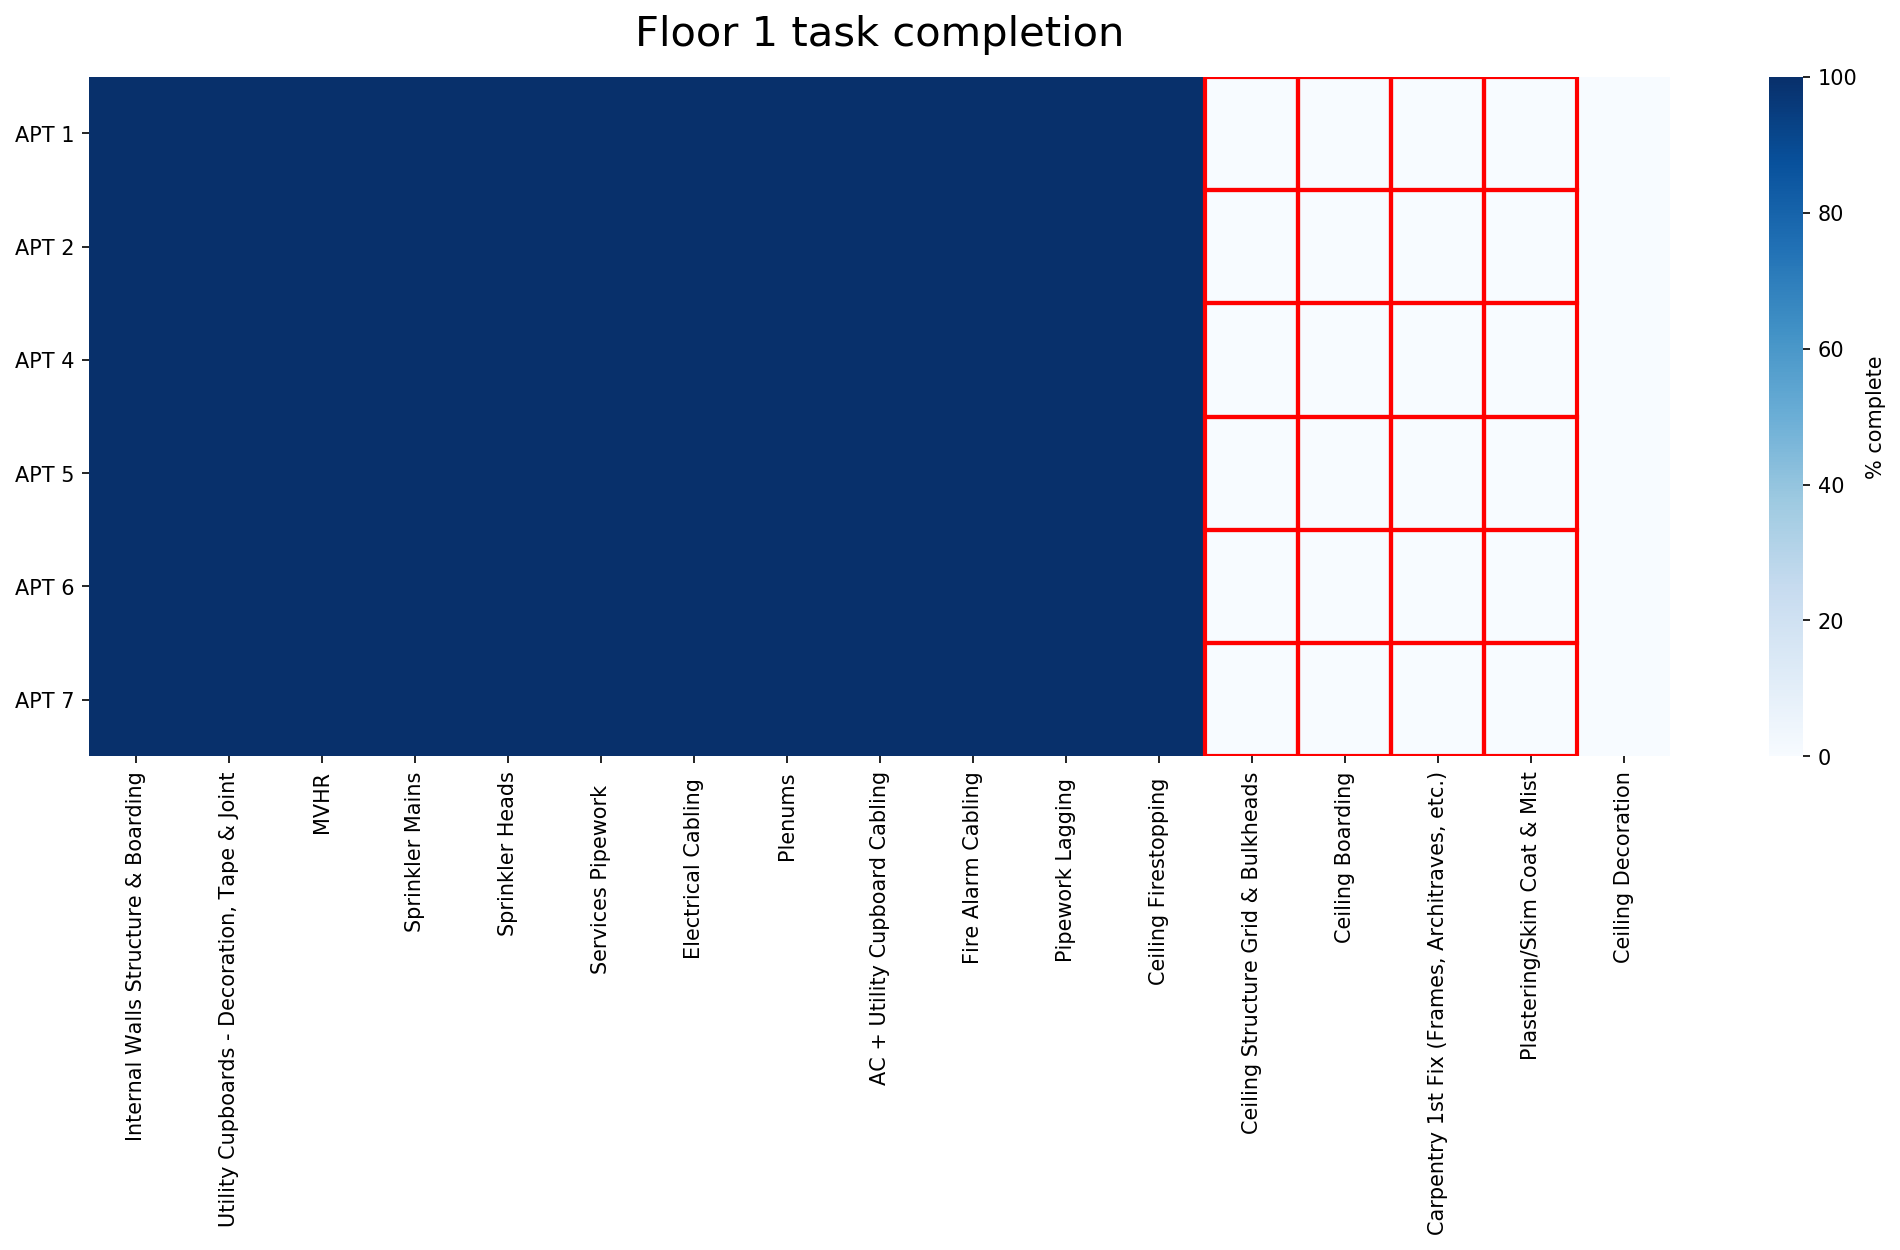

In [290]:
floor_heatmap(1)

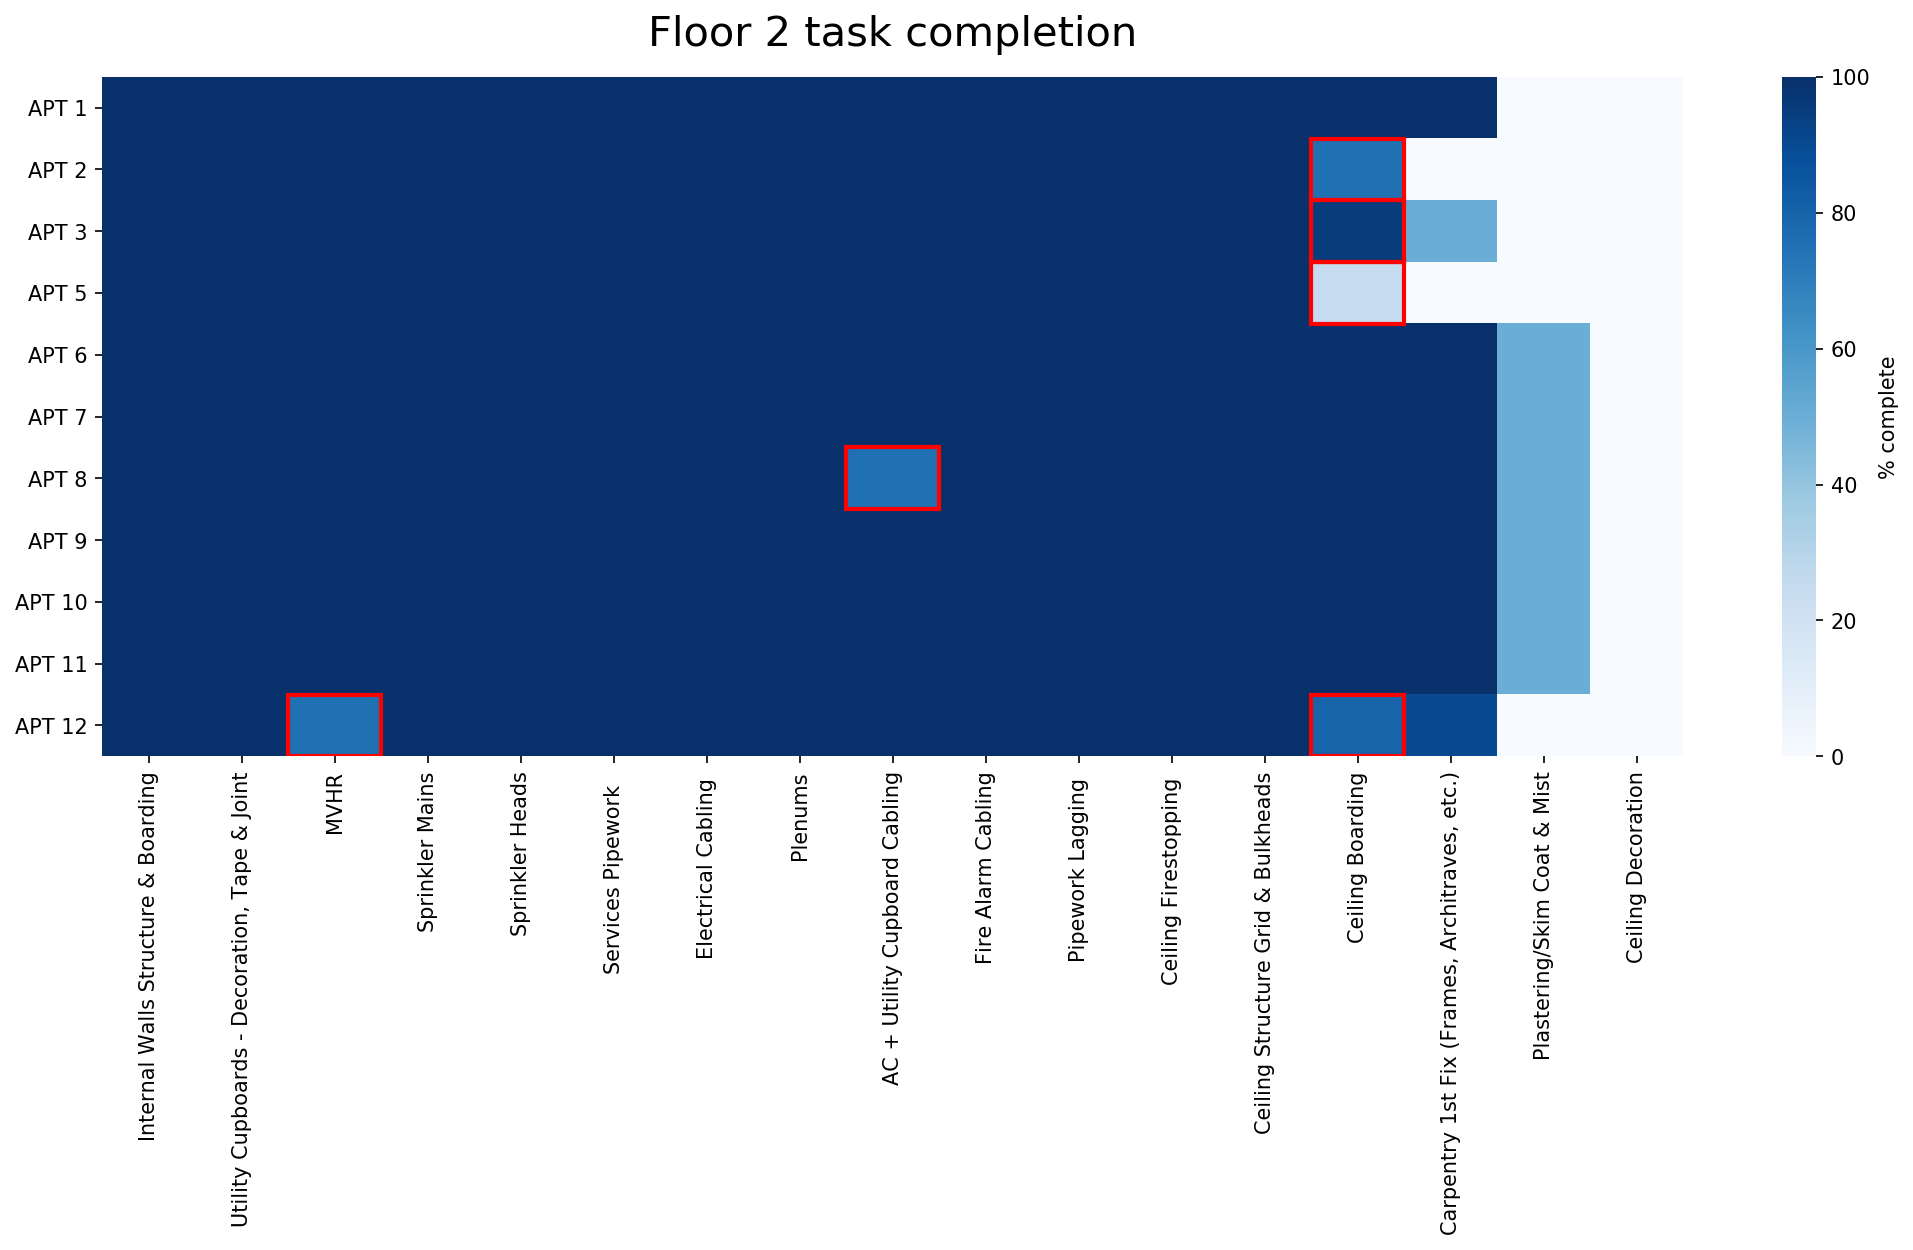

In [291]:
floor_heatmap(2)

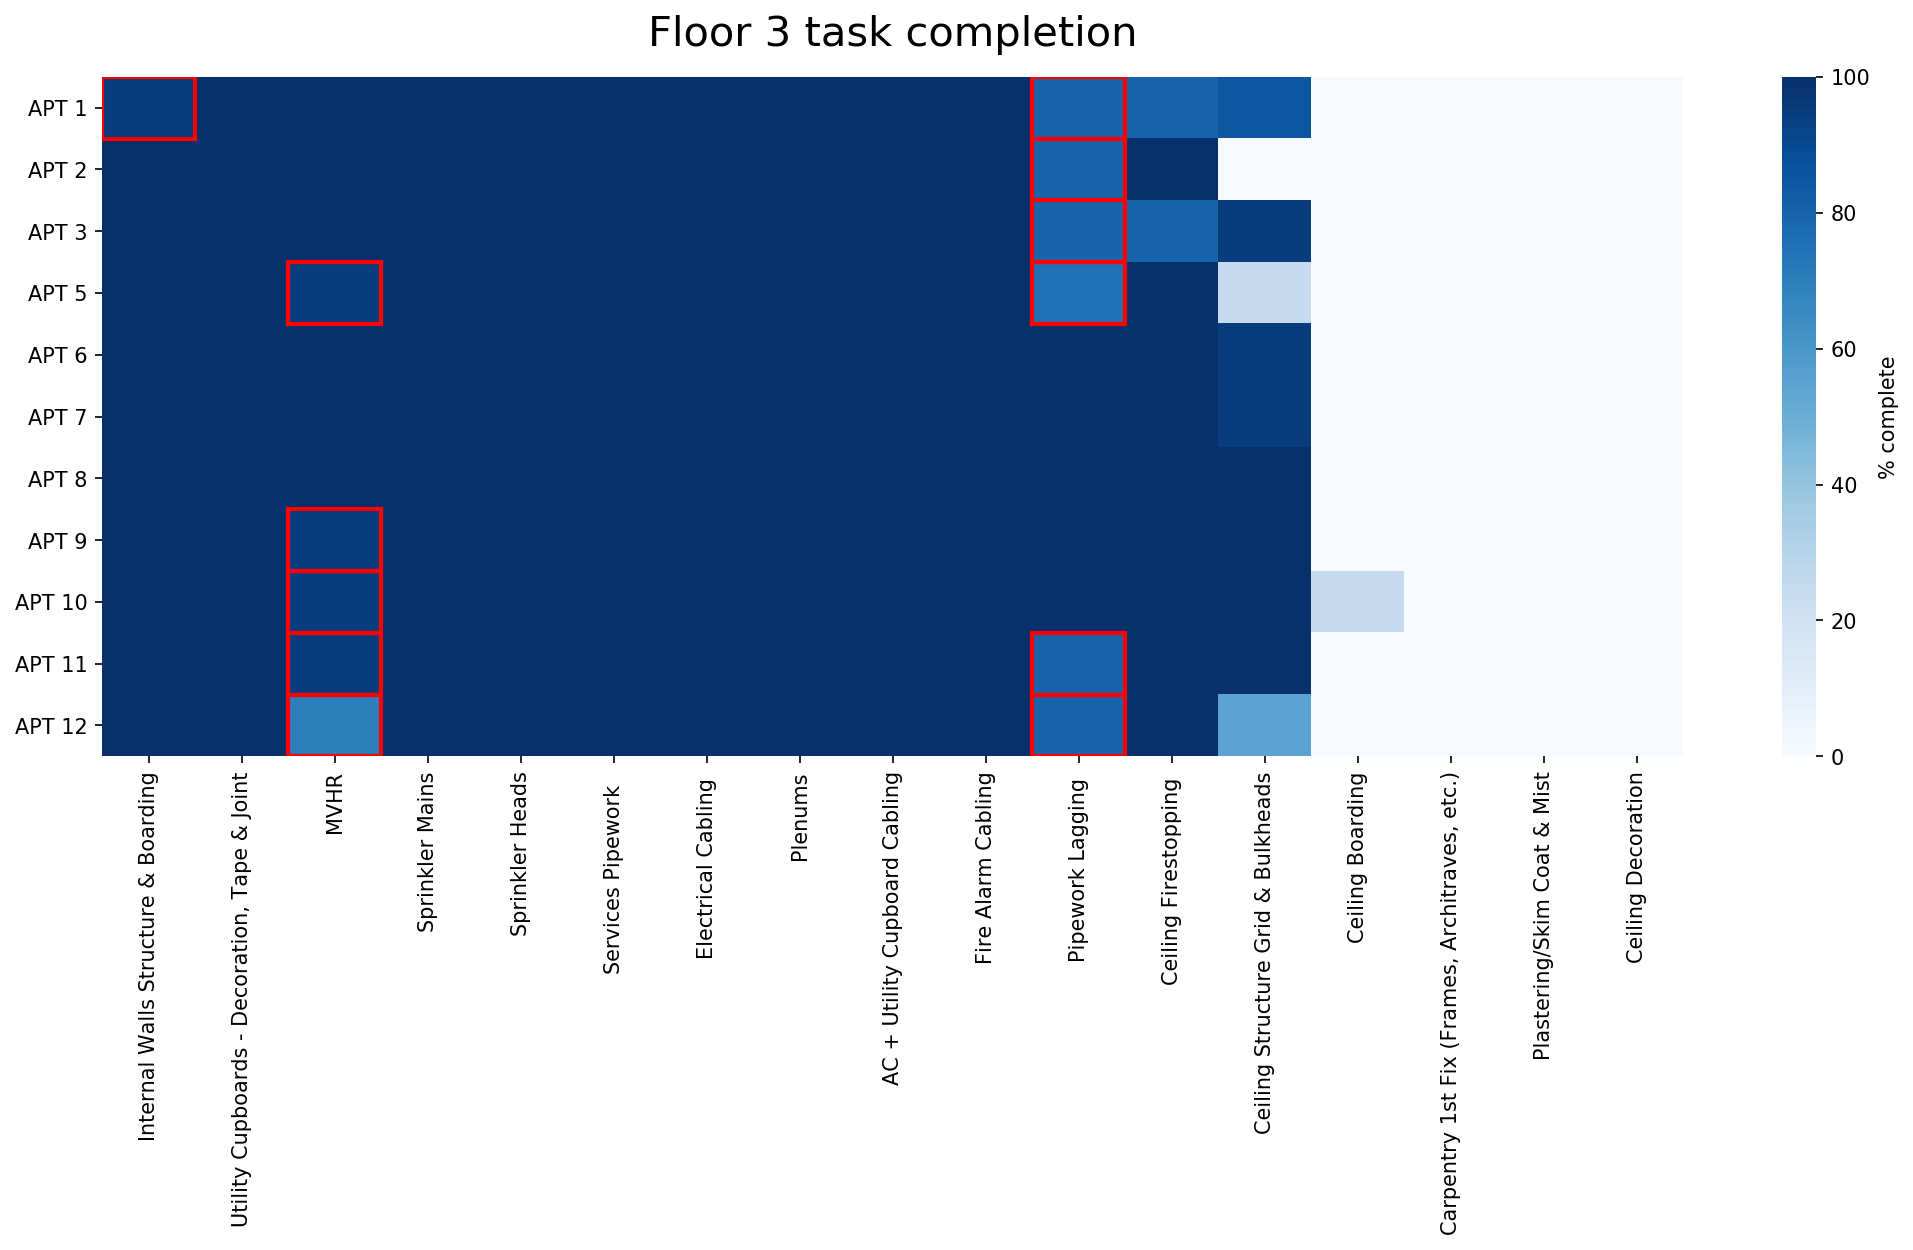

In [292]:
floor_heatmap(3)

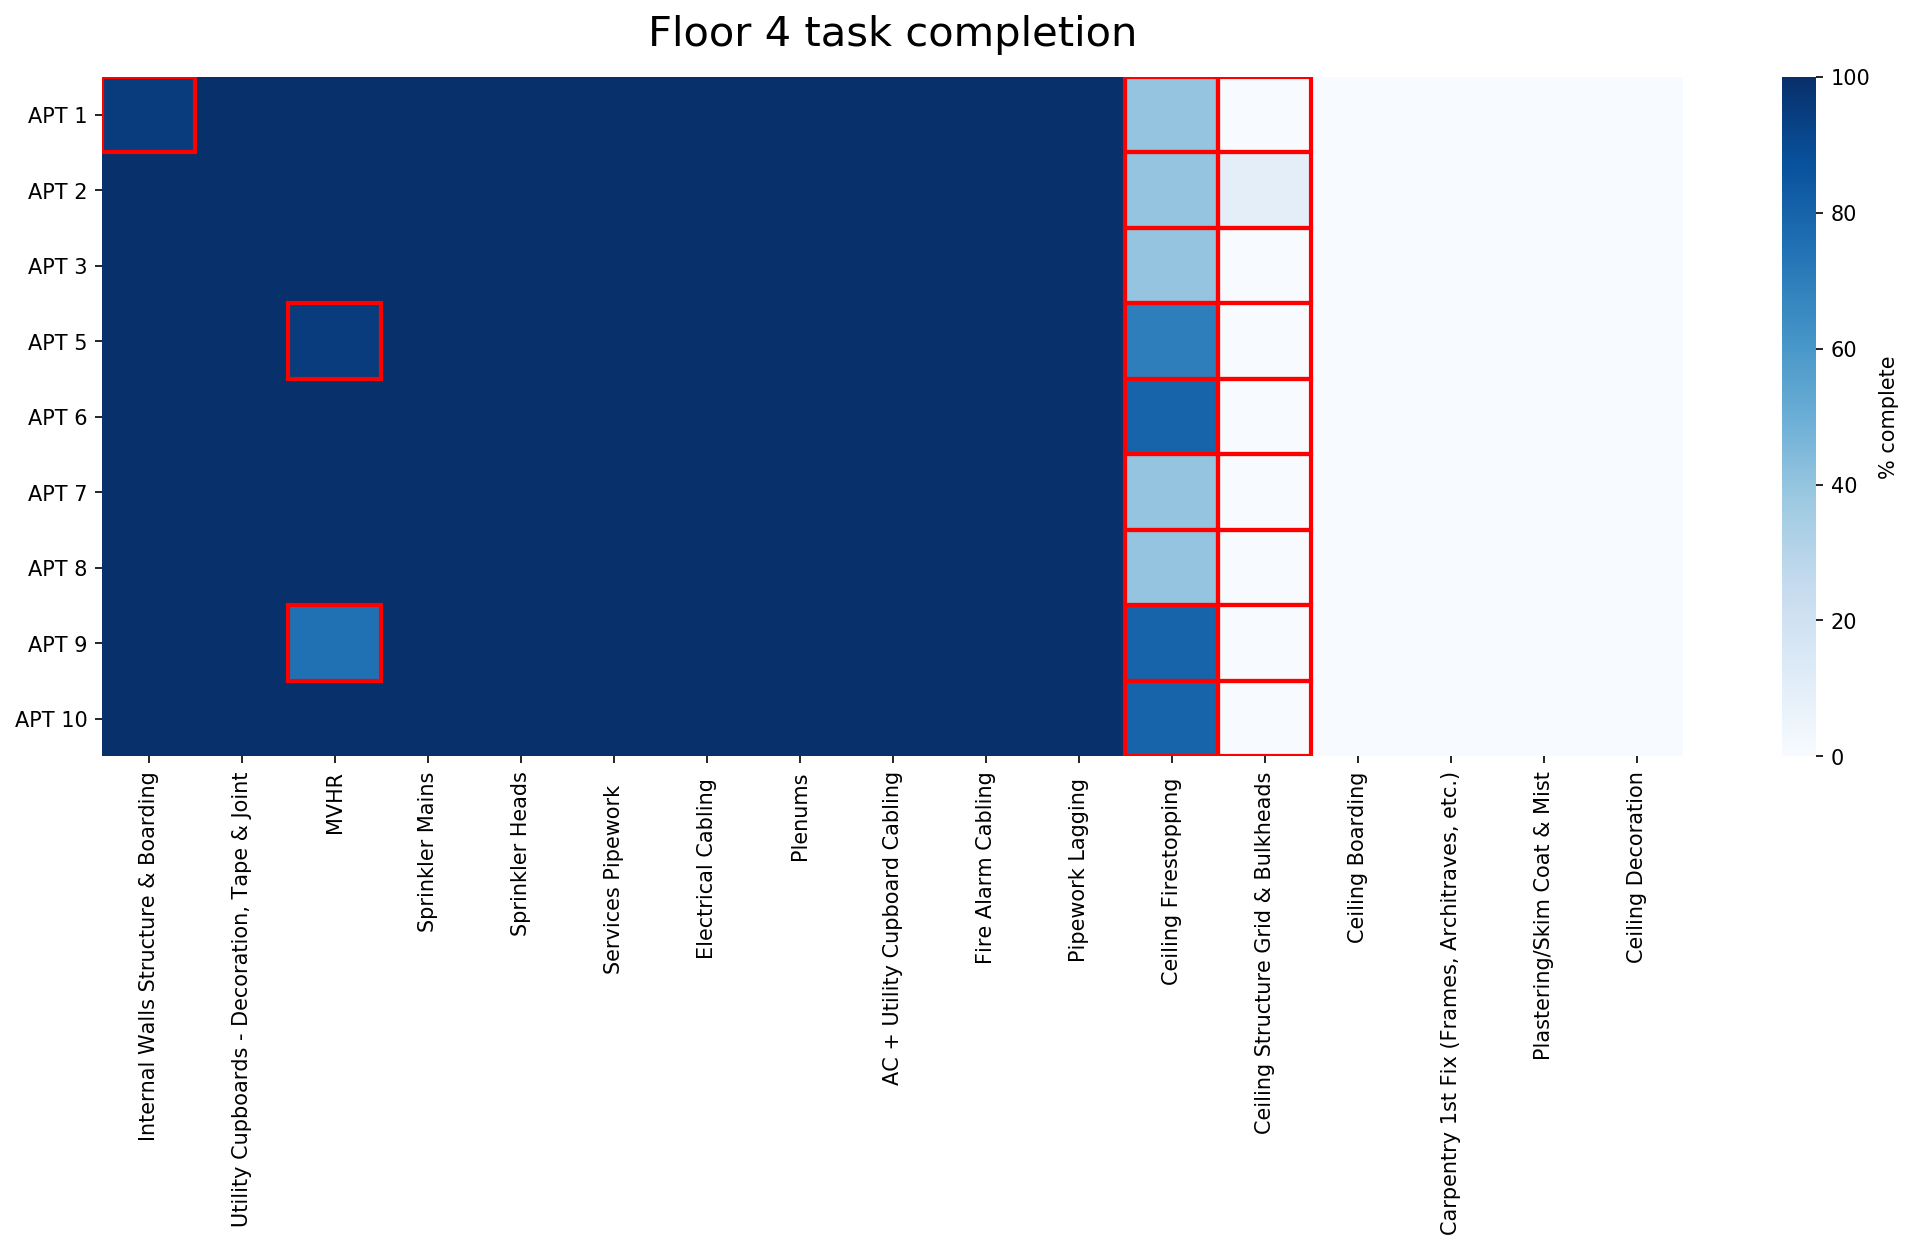

In [293]:
floor_heatmap(4)

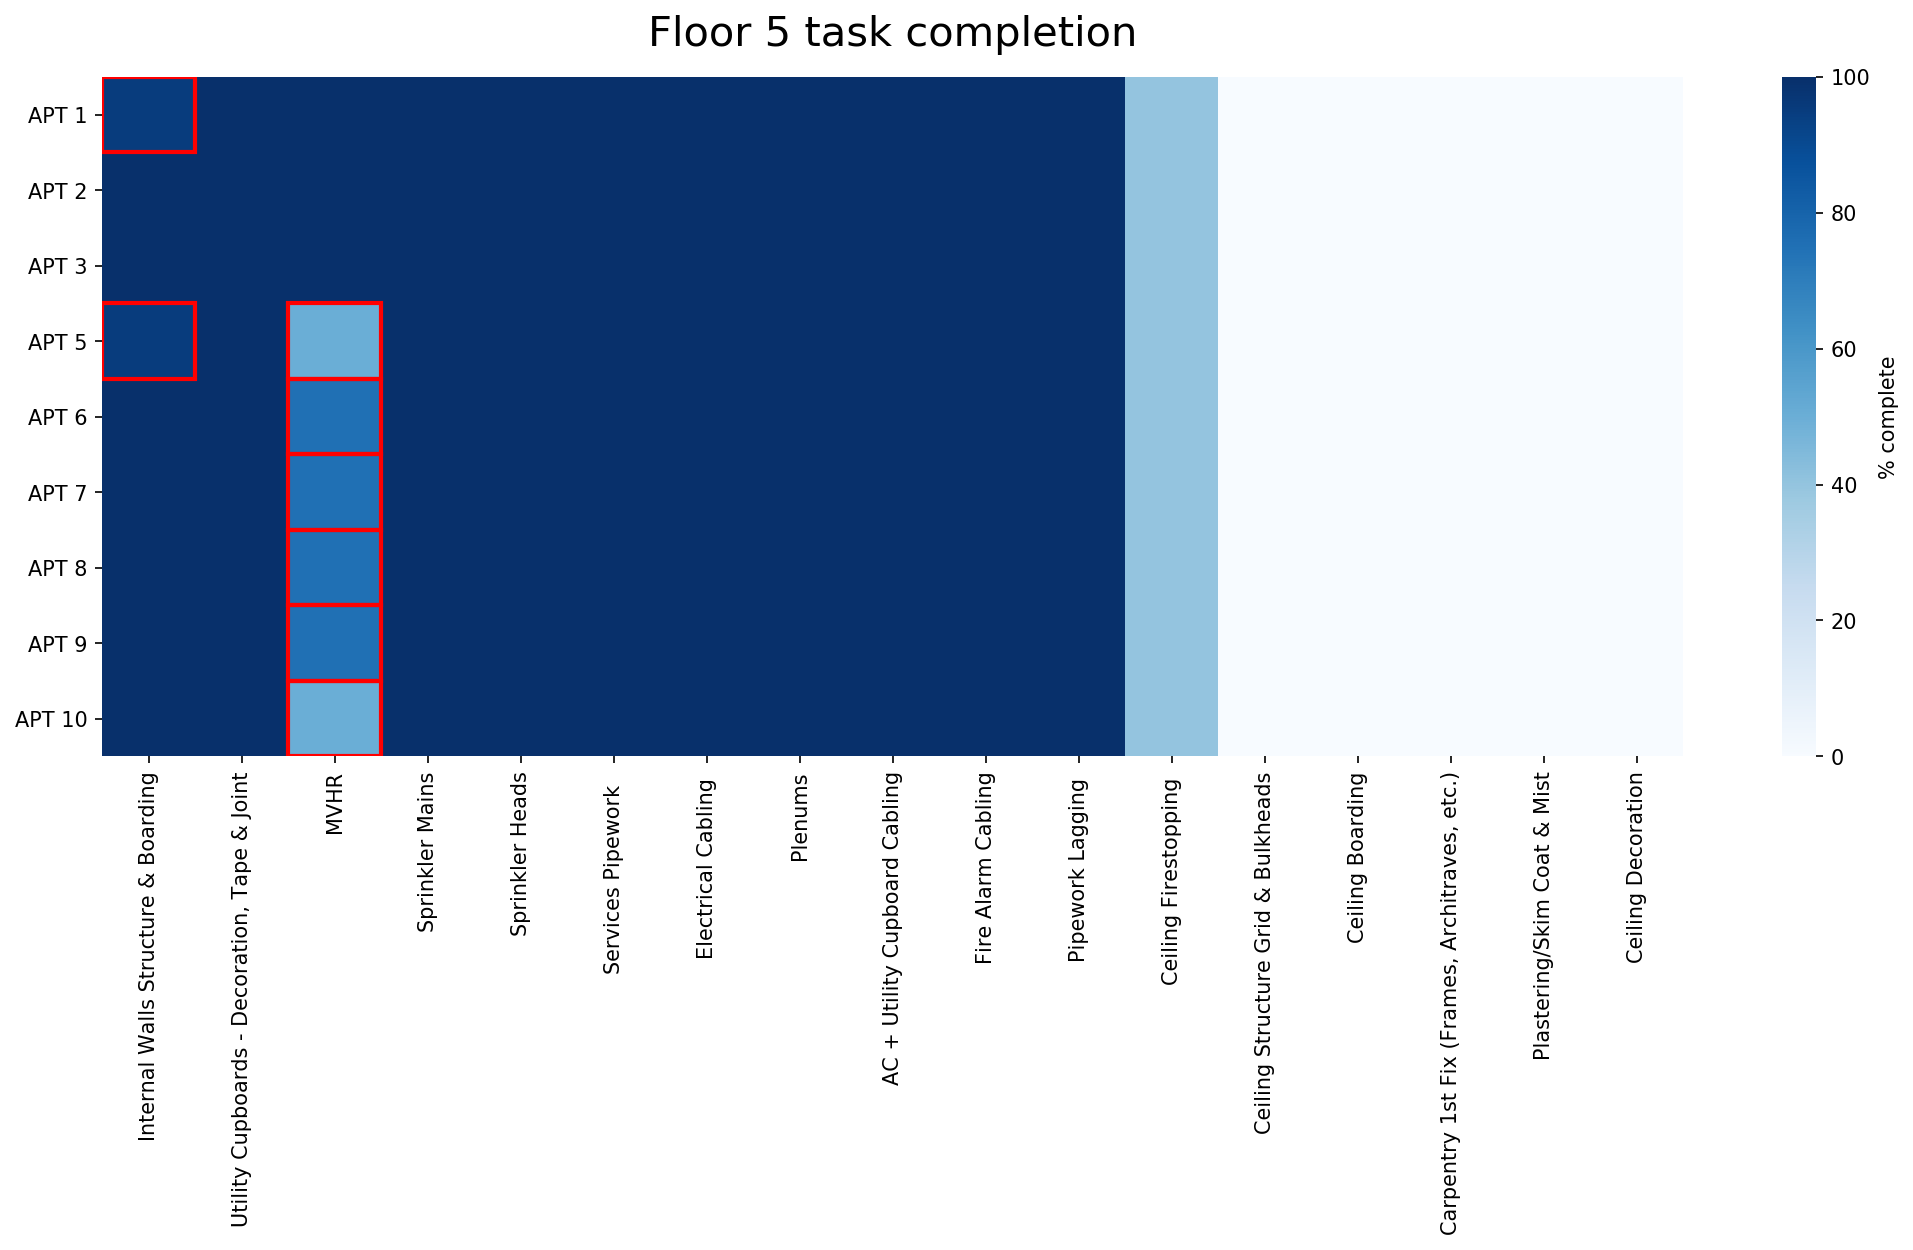

In [294]:
floor_heatmap(5)

# Subcontractor manager (Roseton)

[**Meta-note**: the reason this section deals only with Roseton is that it is the only subcontractor with partially done tasks; in other words, it is the only subcontractor for whom an analysis makes sense this week.]

The aim of the following analysis is to answer the question *Which tasks have to be started / completed in the upcoming week for reaching the schedule?* This information is needed for lookahead planning and for eliminating constraints.

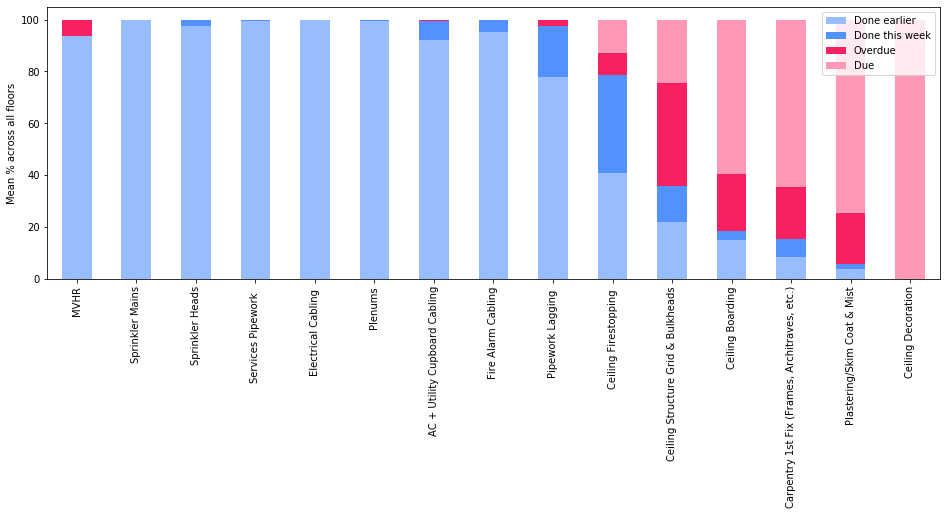

In [272]:
def floor_task_dfs(floor):
    
    current_floor_df = sheets['Floor ' + str(floor)]
    previous_floor_df = sheets['Floor ' + str(floor) + ' (last week)']
    
    # Taking only the tasks that belong to Roseton.
    current_floor_df = current_floor_df[(current_floor_df['TASKGROUP'] == 'Main Services')
                                      | (current_floor_df['TASKGROUP'] == 'Boarding Closure')]
    previous_floor_df = previous_floor_df[(previous_floor_df['TASKGROUP'] == 'Main Services')
                                        | (previous_floor_df['TASKGROUP'] == 'Boarding Closure')]
    ####
    past_deadlines = current_floor_df[current_floor_df['PLANNED END'] <= today]
    ####
    
    tasks = current_floor_df['TASK']

    # Using only the numeric columns.
    current_floor_df = current_floor_df.iloc[:,4:] 
    previous_floor_df = previous_floor_df.iloc[:,4:] 
    
    difs_df = current_floor_df.subtract(previous_floor_df)

    ###### overdues ######
    overdues = (past_deadlines.iloc[:,4:] - 100).mean(axis=1).abs()
    ######################
    
    
    bars_df = pd.DataFrame({'Task': tasks, 
                            'Done earlier': previous_floor_df.mean(axis=1), 
                            'Done this week': difs_df.mean(axis=1),
                            'Overdue': overdues})
    bars_df['Due'] = (bars_df.drop('Task', axis=1).sum(axis=1) - 100).abs()
    
    return bars_df


floor1_df = floor_task_dfs(1)
floor2_df = floor_task_dfs(2)
floor3_df = floor_task_dfs(3)
floor4_df = floor_task_dfs(4)
floor5_df = floor_task_dfs(5)

conc_df = pd.concat([floor1_df, floor2_df, floor3_df, floor4_df, floor5_df]).fillna(0)
means_df = conc_df.groupby(conc_df.index).mean()
ax = means_df.plot(kind='bar', stacked=True, legend=False, color=['#97BDFF', '#5292FF', '#F72060', '#FF98B7'], figsize=(16,5))
ax.set_xticklabels(floor1_df['Task'])
plt.ylabel('Mean % across all floors')

_ = plt.legend(loc="upper right")

Roseton's perpetual scramble after deadlines continued this week, with all unfinished tasks lagging behind schedule. 

The tasks *Pipework Lagging* and *Ceiling Firestopping* had a laudable improvement this week, the latter gaining as much as 38%. On the other hand, the task *Ceiling Structure Grid & Bulkheads* was left with a rather abominable amount of overdue, around 40%. Although it may be that this was caused by this task's dependency on the above two, it is worth probing into the causes, as the relatively small improvement of *Ceiling Structure Grid & Bulkheads* suggests that there is some other issue at play.

In order to finish the project on time, off utmost importance next week would therefore be to focus primarily on *Ceiling Structure Grid & Bulkheads*.